In [1]:
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, Activation, concatenate,Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1.2962e-07)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return (self.b * (2 * x))/ (2**(1/2) * np.pi**(1/4))
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (((2*x*(h1)))-2)/(2*(np.pi**(1/4))*np.sqrt(math.factorial(2)))
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (((2 * x * (h2)))-(4 * h1)) / (2**(3/2)*(np.pi**(1/4))*np.sqrt(math.factorial(3)))

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (((2*x*(h3)))-(6*h2)) / (2**2 *(np.pi**(1/4))*np.sqrt(math.factorial(4)))

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (((2 * x * h4)) - (8 * h3)) / (2**(5/2) * (np.pi**(1/4)) * np.sqrt(math.factorial(5)))

#FROM THIS ON NO MODIFICATION ON WEIGHTS
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

 
class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)
    


2024-05-15 12:15:33.901852: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 12:15:34.380095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 1)            4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           3200      ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 14, 14, 64)           64        ['conv2d[0][0]']          

2024-05-15 12:15:36.646118: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:15:36.663753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 12:15:36.663948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/25


2024-05-15 12:15:38.344254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 12:15:39.181665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-15 12:15:39.671368: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 12:15:39.769538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 12:15:39.770987: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f3b08c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 12:15:39.771023: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): N

469/469 [==============================] - 5s 5ms/step - loss: 0.3565 - accuracy: 0.8870 - val_loss: 0.0534 - val_accuracy: 0.9820
Epoch 2/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0760 - accuracy: 0.9765 - val_loss: 0.0342 - val_accuracy: 0.9898
Epoch 3/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0568 - accuracy: 0.9823 - val_loss: 0.0281 - val_accuracy: 0.9904
Epoch 4/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0455 - accuracy: 0.9854 - val_loss: 0.0280 - val_accuracy: 0.9905
Epoch 5/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.9870 - val_loss: 0.0259 - val_accuracy: 0.9920
Epoch 6/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0355 - accuracy: 0.9886 - val_loss: 0.0262 - val_accuracy: 0.9902
Epoch 7/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.9899 - val_loss: 0.0251 - val_accuracy: 0.9922
Epoch 8/25
469/46

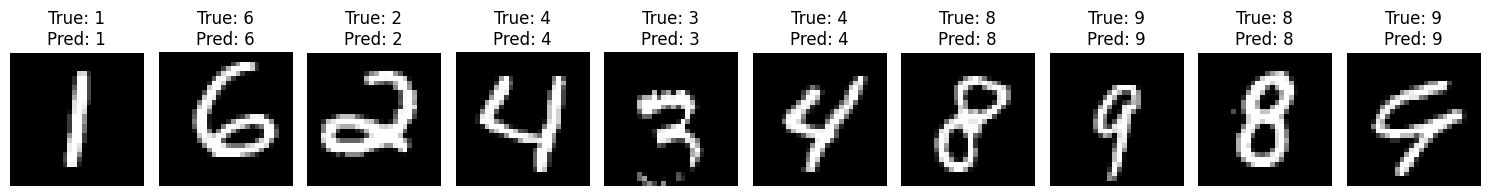

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    #x = Conv2D(filters=filters, kernel_size=(7, 7), padding='same', activation='relu')(x)
    #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    #x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    #x = x_h4=h4(x,x_h2, x_h3)
    #x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    #x = x_h5=h5(x,x_h3, x_h4)
    #x = TensorDecompositionLayer(rank)(x)
    #x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(rate=0.5)(x)
    #x = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = Flatten()(x)


    #x = Dense(filters)(x)
    #x = x_h1 = h1(x)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h2 = h2(x,x_h1)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h3 = h3(x,x_h1,x_h2)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h4 = h4(x,x_h2, x_h3)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 25

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


In [3]:
print(X_train.shape)
#print(X_val.shape)
print(X_val.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)


2024-05-15 11:34:32.923265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           200768    ['batch_normalization[0][0

2024-05-15 11:34:32.940637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 11:34:32.940829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 11:34:32.943010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/25


2024-05-15 11:34:34.635778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 11:34:35.458310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-15 11:34:35.881999: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 11:34:36.042395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 11:34:36.043709: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f771a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 11:34:36.043736: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): N

469/469 [==============================] - 7s 7ms/step - loss: 0.2737 - accuracy: 0.9133 - val_loss: 0.5012 - val_accuracy: 0.8870
Epoch 2/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0726 - accuracy: 0.9777 - val_loss: 0.0262 - val_accuracy: 0.9913
Epoch 3/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0211 - val_accuracy: 0.9929
Epoch 4/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0433 - accuracy: 0.9868 - val_loss: 0.0219 - val_accuracy: 0.9926
Epoch 5/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0369 - accuracy: 0.9884 - val_loss: 0.0244 - val_accuracy: 0.9916
Epoch 6/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0328 - accuracy: 0.9897 - val_loss: 0.0230 - val_accuracy: 0.9922
Epoch 7/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0223 - val_accuracy: 0.9924
Epoch 8/25
469/46

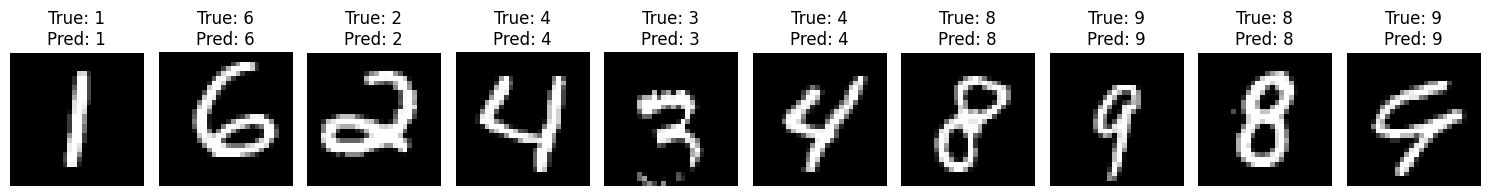

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    x = Conv2D(filters=filters, kernel_size=(7, 7), padding='same', activation='relu')(x)
    #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    #x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    #x = x_h4=h4(x,x_h2, x_h3)
    #x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    #x = x_h5=h5(x,x_h3, x_h4)
    #x = TensorDecompositionLayer(rank)(x)
    #x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)
    #x = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = Flatten()(x)


    #x = Dense(filters)(x)
    #x = x_h1 = h1(x)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h2 = h2(x,x_h1)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h3 = h3(x,x_h1,x_h2)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h4 = h4(x,x_h2, x_h3)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 25

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 1)            4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           3200      ['batch_normalization[0][0]'] 
                                                                                                  
 h1_layer (H1Layer)          (None, 14, 14, 64)           64        ['conv2d[0][0]']          

2024-05-15 11:54:28.938530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 11:54:28.955883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 11:54:28.956076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/25


2024-05-15 11:54:30.647136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-15 11:54:31.485338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-15 11:54:31.960648: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-15 11:54:32.067926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-15 11:54:32.069418: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f167e123c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 11:54:32.069429: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0

469/469 [==============================] - 6s 5ms/step - loss: 0.3495 - accuracy: 0.8858 - val_loss: 0.0509 - val_accuracy: 0.9821
Epoch 2/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0854 - accuracy: 0.9726 - val_loss: 0.0412 - val_accuracy: 0.9862
Epoch 3/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0620 - accuracy: 0.9799 - val_loss: 0.0275 - val_accuracy: 0.9910
Epoch 4/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0513 - accuracy: 0.9834 - val_loss: 0.0325 - val_accuracy: 0.9901
Epoch 5/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0471 - accuracy: 0.9852 - val_loss: 0.0278 - val_accuracy: 0.9910
Epoch 6/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0415 - accuracy: 0.9865 - val_loss: 0.0246 - val_accuracy: 0.9925
Epoch 7/25
469/469 [==============================] - 2s 4ms/step - loss: 0.0377 - accuracy: 0.9874 - val_loss: 0.0249 - val_accuracy: 0.9920
Epoch 8/25
469/46

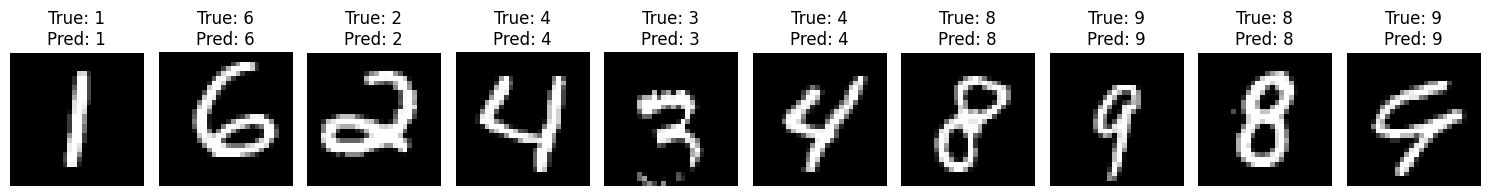

In [2]:
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def build_model(input_shape, num_classes, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    #x = BatchNormalization()(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(filters=128, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=filters, kernel_size=(7, 7), strides=2, padding='same',kernel_initializer="he_normal")(x)
    x = x_h1 = h1(x)
    x = Conv2D(filters=filters, kernel_size=(5, 5),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    #x = Conv2D(filters=filters, kernel_size=(3, 3),padding='same',kernel_initializer="he_normal")(x)
    #x = TensorDecompositionLayer(rank)(x)
    #x = x_h4=h4(x,x_h2, x_h3)
    #x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    #x = x_h5=h5(x,x_h3, x_h4)
    #x = TensorDecompositionLayer(rank)(x)
    #x = Conv2D(filters=filters, kernel_size=(3, 3))(x)
    x = MaxPooling2D((4,4))(x)
    x = Dropout(rate=0.5)(x)
    x = Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = Flatten()(x)


    #x = Dense(filters)(x)
    #x = x_h1 = h1(x)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h2 = h2(x,x_h1)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h3 = h3(x,x_h1,x_h2)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h4 = h4(x,x_h2, x_h3)
    #x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    #x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)


    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


# Load and preprocess the MNIST data
(X_train, y_train), (X_val, y_val) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_val = X_val.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)

input_shape = (28, 28, 1)
filters = 64
model_mnist = build_model(input_shape, 10,filters)
optimizer = Adam(learning_rate=0.001)
model_mnist.summary()
model_mnist.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 25

history = model_mnist.fit(X_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(X_val, y_val))

val_loss, val_acc = model_mnist.evaluate(X_val, y_val, verbose=0)
print(f"Validation accuracy: {val_acc:.4f}")

# Visualize some sample predictions
num_test_samples = 10
indices = np.random.choice(len(X_val), num_test_samples)
X_test_samples = X_val[indices]
y_true_samples = np.argmax(y_val[indices], axis=1)
y_pred_samples = np.argmax(model_mnist.predict(X_test_samples), axis=1)

plt.figure(figsize=(15, 5))
for i in range(num_test_samples):
    plt.subplot(2, num_test_samples, i + 1)
    plt.imshow(X_test_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.title(f"True: {y_true_samples[i]}\nPred: {y_pred_samples[i]}")
plt.tight_layout()
plt.show()
